# Machine Translation with Sequence-to-Sequence and RNNs

This lab will demonstrate fundamentals of Sequence-to-sequence RNN model for translation.  Using various libraries: `pandas`, `numpy`, `sklearn`, `seaborn`, `matplotlib`, `torch`, `spacy`.  (NOTE: we will use `spacy` for the natural language processing (NLP). 

Will demonstrate use of the Multi30K dataset (a large machine translation dataset with extensive English to German sentence pairs). 


In [11]:
import os
import sys
import warnings

warnings.filterwarnings('ignore')
os.environ['PYTHONWARNINGS'] = 'ignore'

# Install packages
os.system(f"{sys.executable} -m pip install -qq 'numpy<2.0' 2>/dev/null")
os.system(f"{sys.executable} -m pip install -qq torch==2.2.2 torchvision==0.17.2 torchtext==0.17.2 2>/dev/null")
os.system(f"{sys.executable} -m pip install -qq 'spacy<3.8' 'thinc<8.3' 2>/dev/null")
os.system(f"{sys.executable} -m pip install -qq pandas matplotlib seaborn scikit-learn portalocker 2>/dev/null")
os.system(f"{sys.executable} -m pip install -qq torchdata==0.7.1 nltk 2>/dev/null")
os.system(f"{sys.executable} -m spacy download en_core_web_sm 2>/dev/null")

os.system(f"{sys.executable} -m spacy download de_core_news_sm 2>/dev/null")

# Verify
print("Installation complete! Testing imports...")
import torch
import spacy
import numpy as np
print(f"✓ NumPy {np.__version__}")
print(f"✓ PyTorch {torch.__version__}")
print(f"✓ spaCy {spacy.__version__}")

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 5.5 MB/s  0:00:02 eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 5.0 MB/s  0:00:02m0:00:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
Installation complete! Testing imports...
✓ NumPy 1.26.4
✓ PyTorch 2.2.2
✓ spaCy 3.7.5


## Import required libraries

In [12]:
from torchtext.data.utils import get_tokenizer #import get_tokenizer function from torchtext
from torchtext.vocab import build_vocab_from_iterator #import function that builds vocabulary from tokenized text
from nltk.translate.bleu_score import sentence_bleu #Used for evals/BLEU score metrics
from torchtext.datasets import multi30k, Multi30k #Import the utilities/functions to access Multi30k dataset
from typing import Iterable, List # For type hints
from torch.nn.utils.rnn import pad_sequence #for batch sequence length noramlization
from torch.utils.data import DataLoader #for creation of data batches
from torchdata.datapipes.iter import IterableWrapper, Mapper
import torchtext #Torchtext for NLP tasks

import torch #Main PyTorch library for tensor operations
import torch.nn as nn #utilities for building blocks of the neural network (e.g. layers, loss functions)
import torch.optim as optim #optimization algo for model weight updates during training

#suppress warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

# Sequence to Sequence Model

We will implement a Seq2Seq model in PyTorch.  Sequence-to-sequence or `seq2seq` models useful for: 
- Translation from source language to target language
- Chat bots (e.g. answering question or generatugin natural language responses to input sequences)
- Summarization

## Sequence-to-sequence (seq2seq) architecture
- Seq2seq utilize an encoder-decoder structure: (1) the encoder encodes input seq into fixed-dimensional representation context vector (ht) (2) the decoder generates output sequence based on encoded context vector.
- This architecture takes input token x_t and embedding layer converts word ID to dense vector. RNN decoder takes the embedded word and previous hidden state (h_t) to output new hidden state h_{t+1}. A Linear layer projects the new hidden state to vocab size and outputs probability distribution for next word prediction. This process repeats, with each predicted word becoming the next input x_t.

In [61]:
#Define the encoder class

class Encoder(nn.Module): #Encoder class inherits from PyTorch nn.Module base class
    def __init__(self, vocab_len, emb_dim, hid_dim, n_layers, dropout_prob):
        super().__init__() #run initialization code from parent class

        self.hid_dim = hid_dim # Save hidden size (for decoder)
        self.n_layers = n_layers # Save layer count (for decoder)

        #Create the three layers
        self.embedding = nn.Embedding(vocab_len, emb_dim) #Word to vec lookup
        self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, input_batch): #forward runs encoding to convert input sentences into context vectors
        embed = self.dropout(self.embedding(input_batch)) #Store word vectors in embed + dropout
        #embed = embed.to(device) #Move to device for computation
        outputs, (hidden, cell) = self.lstm(embed) # Pass embeddings through LSTM, get outputs and states
        return hidden, cell #return encoded representation

In [14]:
#Optional but recommended: Test encoder and verify functionality
vocab_len = 8
emb_dim = 10
hid_dim=8
n_layers=1
dropout_prob=0.5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder_t = Encoder(vocab_len, emb_dim, hid_dim, n_layers, dropout_prob).to(device)

src_batch = torch.tensor([[0,3,4,2,1]])
# you need to transpose the input tensor as the encoder LSTM is in Sequence_first mode by default
src_batch = src_batch.t().to(device)
print("Shape of input(src) tensor:", src_batch.shape)
hidden_t , cell_t = encoder_t(src_batch)
print("Hidden tensor from encoder:",hidden_t ,"\nCell tensor from encoder:", cell_t)

Shape of input(src) tensor: torch.Size([5, 1])
Hidden tensor from encoder: tensor([[[ 0.1518, -0.0946, -0.3460, -0.2502, -0.0561, -0.0278, -0.1989,
           0.1697]]], grad_fn=<StackBackward0>) 
Cell tensor from encoder: tensor([[[ 0.2645, -0.2014, -0.6276, -0.5840, -0.0856, -0.0964, -0.3747,
           0.3822]]], grad_fn=<StackBackward0>)


In [39]:
'''
The decoder generates target language words one by one by taking the previous word and encoder context, 
processing them through the embedding layer/LTSM and outputting probability scores across the entire
target set vocabulary.  

Each forward pass produces one word prediction along with updated states for the next step, allowing the
decoder to build translations word by word while maintaining context from both the source sentence and previously
generated words.
'''

#Implement decoder class that inherits from nn.Module
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__() 

        self.output_dim = output_dim #Store target vocab size (output_dim is vocab size)
        self.hid_dim = hid_dim #Store hidden dimension
        self.n_layers = n_layers #Store num of LTSM layers

        self.embedding = nn.Embedding(output_dim, emb_dim) # Create learnable lookup table for target word ID → vector conversion
        self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout) # Create LSTM decoder with input size emb_dim
        self.fc_out = nn.Linear(hid_dim, output_dim) # Linear layer to project hidden states to vocab size
        self.softmax = nn.LogSoftmax(dim=1) # Convert logits to log probabilities for word prediction
        self.dropout = nn.Dropout(dropout) # Dropout layer for regularization during training

    # Forward method processes one word at a time through decoder, generating next word prediction
    def forward(self, input, hidden, cell):
        # input=[batch_size], hidden/cell=[n_layers, batch_size, hid_dim]
        
        # Add sequence dimension for LSTM compatibility
        input = input.unsqueeze(0)  # [1, batch_size]
        
        # Convert word IDs to vectors and apply dropout
        embedded = self.dropout(self.embedding(input))  # [1, batch_size, emb_dim]
        
        # Process through LSTM with previous states
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        # output=[1, batch_size, hid_dim], hidden/cell=[n_layers, batch_size, hid_dim]
        
        # Remove seq dimension and project to vocabulary size
        prediction_logit = self.fc_out(output.squeeze(0))  # [batch_size, output_dim]
        
        # Convert logits to log probabilities
        prediction = self.softmax(prediction_logit)  # [batch_size, output_dim]
        
        return prediction, hidden, cell

In [42]:
#Test decoder by creating an instance 
output_dim = 6
emb_dim=10
hid_dim = 8
n_layers=1
dropout=0.5
decoder_t = Decoder(output_dim, emb_dim, hid_dim, n_layers, dropout).to(device)

Next we will create a training loop that connects encoder output to decoder input.  The encoder runs once (to process the entire input sequence) to create the summary (hidden and cell states), then the decoder runs multiple times (once per output word to iteratively generates the output sequence word by word) to build the translation word by word.

In [43]:
import random

#Create the encoder-decoder connection to allow model to process (src, trg) pairs to generate the translation
#Implement the decoder training loop that generates translations step by step

# Setup for decoder training loop
teacher_forcing_ratio = 0.5  # During training: balances learning from correct answers vs own predictions
trg = torch.tensor([[0],[2],[3],[5],[1]]).to(device)  #Target sequence (test example, real examples will come from Multi30K dataset)
batch_size = trg.shape[1] #save batch dimension to batch_size
trg_len = trg.shape[0] #Save seq length 
trg_vocab_size = decoder_t.output_dim #Get target vocab size

# Initialize storage for all predictions; outputs_t tensor collects decoder's probability distributions for what model thinks each word should be at every step of generation 
outputs_t = torch.zeros(trg_len, batch_size, trg_vocab_size).to(device)

# Move encoder outputs to device
hidden_t = hidden_t.to(device)
cell_t = cell_t.to(device)

# Start with <bos> token; extracts first row position 0 from target sequence
input = trg[0,:] #extract row 0 , all columns

# Generate one word at a time - the for loop runs decoder (Takes input token + states → produces word probabilities + updated states) , stores the productions in output_t, 
for t in range(1, trg_len):
    # Run decoder
    output_t, hidden_t, cell_t = decoder_t(input, hidden_t, cell_t)
    outputs_t[t] = output_t
    
    # Teacher forcing: use true target or prediction
    teacher_force = random.random() < teacher_forcing_ratio
    top1 = output_t.argmax(1)
    input = trg[t] if teacher_force else top1

print(outputs_t, outputs_t.shape)

tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[-1.8125, -2.1189, -1.8993, -1.4792, -2.1225, -1.5171]],

        [[-1.7986, -2.0820, -1.9791, -1.4562, -1.9319, -1.6420]],

        [[-1.7508, -2.1017, -1.9372, -1.4581, -2.0165, -1.6388]],

        [[-1.7903, -2.0690, -1.9052, -1.5341, -1.9829, -1.5865]]],
       device='mps:0', grad_fn=<CopySlices>) torch.Size([5, 1, 6])


In [44]:
#Extract actual predicted word IDs from probability distributions
print("trg = ")
pred_tokens = outputs_t.argmax(2)
print(pred_tokens)

trg = 
tensor([[0],
        [3],
        [3],
        [3],
        [3]], device='mps:0')


# Implementing Seq2Seq model in PyTorch (Defining the model)

We will connect the encoder and decoder components to create the seq2seq model.   

In [45]:
# Seq2Seq class combines encoder and decoder into complete translation model

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, trg_vocab): #parameters needed for the translation process
        super().__init__()

        self.encoder = encoder #store encoder instance
        self.decoder = decoder #store decoder instance
        self.device = device  
        self.trg_vocab = trg_vocab #store target vocabulary (for special tokens)

        #Ensure encoder and decoder compatibility
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"

    #Forward method orchestrates the translation process
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):

        # Extract dimensions from the target tensor
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        # Initialize tensor to collect all decoder outputs
        # Tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        # Encode entire source sequence to get context vecs
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        hidden = hidden.to(device)
        cell = cell.to(device)

        #Start decoding with <bos> token
        input = trg[0,:]

        # Generate target sequence one token at a time
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1
        return outputs

# PyTorch Model Training (Training the model)

In [46]:
# Training function that runs one epoch of training on the seq2seq model

def train(model, iterator, optimizer, criterion, clip):
    model.train()  # Set model to training mode (enables dropout)
    epoch_loss = 0
    
    # Create progress bar wrapper
    train_iterator = tqdm(iterator, desc="Training", leave=False)
    
    # Process each batch of source-target sentence pairs
    for i, (src, trg) in enumerate(train_iterator):  # FIXED: Use train_iterator not iterator
        src = src.to(device)
        trg = trg.to(device)
        optimizer.zero_grad()  # Clear gradients from previous step
        
        # Forward pass: encoder processes src, decoder generates predictions for trg
        output = model(src, trg)
        
        # Reshape for loss calculation: skip <sos> token at position 0
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)  # Flatten predictions, skip first
        trg = trg[1:].contiguous().view(-1)  # Flatten targets, skip <sos>
        
        # Calculate cross-entropy loss between predictions and true targets
        loss = criterion(output, trg)
        
        # Backpropagation and gradient clipping
        loss.backward()  # Compute gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)  # Prevent gradient explosion
        
        # Update model weights
        optimizer.step()
        
        # Update progress bar with current loss
        train_iterator.set_postfix(loss=loss.item())
        epoch_loss += loss.item()
    
    return epoch_loss / len(iterator)  # Return average loss per batch

# Evaluate Model

In [47]:
'''
Define the function to evaluate the model
'''

def evaluate(model, iterator, criterion): #takes model, iterator and criterion as arguments with evaluation data provided by iterator

    model.eval() #Set the model to evaluation mode
    epoch_loss = 0 #initialize epoch_loss to track accumulated loss during eval

    # Wrap iterator with tqdm for progress logging
    valid_iterator = tqdm(iterator, desc="Training", leave=False)

    with torch.no_grad(): #torch.no_grad() block ensures that no gradients computed during evaluation

        for i, (src,trg) in enumerate(iterator):

            src = src.to(device)
            trg = trg.to(device)

            #Call the model with model(src, trg, 0) to obtain predictions for the target sequences
            output = model(src, trg, 0) #turn off teacher forcing 

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]

            output = output[1:].view(-1, output_dim)

            trg = trg[1:].contiguous().view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg) #The loss between reshaped output and trg tensors is calculated with criterion
            # Update tqdm progress bar with the current loss
            valid_iterator.set_postfix(loss=loss.item())

            epoch_loss += loss.item()

    return epoch_loss / len(list(iterator)) #return average loss per batch for the evaluation

# Data Preparation and Processing from Multi30K dataset

In [48]:
import os
import sys

os.system(f"{sys.executable} -m pip install datasets")


Defaulting to user installation because normal site-packages is not writeable


0

In [49]:
#Load the Multi30K Dataset with English to German Sentence Pairs
from datasets import load_dataset
dataset = load_dataset("bentrevett/multi30k")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['en', 'de'],
        num_rows: 29000
    })
    validation: Dataset({
        features: ['en', 'de'],
        num_rows: 1014
    })
    test: Dataset({
        features: ['en', 'de'],
        num_rows: 1000
    })
})


In [50]:
%run Multi30KDataLoader.py

Loading Multi30K dataset...
Dataset loaded successfully!
Training samples: 29000
Validation samples: 1014
Test samples: 1000
Building vocabulary for de...
  Vocabulary size for de: 19214
Building vocabulary for en...
  Vocabulary size for en: 10837

Creating DataLoaders...

Train DataLoader: 3625 batches
Valid DataLoader: 126 batches

Batch shapes:
  Source: torch.Size([6, 8]) (seq_len, batch_size)
  Target: torch.Size([11, 8]) (seq_len, batch_size)

Sample translation pair:
  German: <bos> @@ <eos>
  English: <bos> Front stroke swimming race roped off lap areas . <eos>


In [22]:
#Sanity checks
# Check vocabulary sizes
print(f"German vocabulary size: {len(vocab_transform['de'])}")
print(f"English vocabulary size: {len(vocab_transform['en'])}")

German vocabulary size: 19214
English vocabulary size: 10837


In [51]:
train_dataloader, valid_dataloader = get_translation_dataloaders(batch_size = 4)#,flip=True)

In [52]:
src, trg = next(iter(train_dataloader)) #Check the src and trg tensors
src,trg

(tensor([[    2,     2,     2,     2],
         [ 5510,  5510, 12642,    84],
         [    3,     3,     8,  2356],
         [    1,     1,  1701,     4],
         [    1,     1,     3,     3]]),
 tensor([[   2,    2,    2,    2],
         [6650,  216,    6,   83],
         [4623,  110, 3398,   82],
         [ 259, 3913,  202,    7],
         [ 172, 1650,  109,    4],
         [9953, 3823,   37,  708],
         [ 115,   71,    3,    5],
         [ 692, 2808,    1,    3],
         [3428, 2187,    1,    1],
         [   5,    5,    1,    1],
         [   3,    3,    1,    1]]))

In [53]:
data_itr = iter(train_dataloader)
# moving forward in the dataset to reach sequences of longer length for illustration purpose.
for n in range(1000):
    german, english= next(data_itr)

for n in range(3):
    german, english=next(data_itr)
    german=german.T
    english=english.T
    print("________________")
    print("german")
    for g in german:
        print(index_to_german(g))
    print("________________")
    print("english")
    for e in english:
        print(index_to_eng(e))


________________
german
<bos> Eine Gruppe Menschen protestiert in einer Stadt . <eos>
<bos> Eine Gruppe teilt ihre politischen Ansichten mit . <eos>
<bos> Mehrere Personen sitzen an einem felsigen Strand . <eos>
<bos> Zwei sitzende Personen mit Hüten und Sonnenbrillen . <eos>
________________
english
<bos> A group of people protesting in a city . <eos> <pad> <pad>
<bos> A group is letting their political opinion be known . <eos> <pad>
<bos> A group of people are sitting on a rocky beach . <eos>
<bos> Two people sitting in hats and shades . <eos> <pad> <pad> <pad>
________________
german
<bos> Ein kleiner Junge mit Hut beim Angeln . <eos>
<bos> Diese zwei Frauen haben Spaß im Giorgio's . <eos>
<bos> Zwei kleine Kinder schlafen auf dem Sofa . <eos>
<bos> Zwei junge Mädchen marschieren in einem Umzug . <eos>
________________
english
<bos> A young boy in a hat is fishing by himself . <eos>
<bos> These two women is at Giorgio 's having fun . <eos> <pad>
<bos> Two young children are asleep o

# Model Training

In [54]:
import random

# Sets random seed for various libraries and modules. This is done to make the results reproducible:

SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [55]:
INPUT_DIM = len(vocab_transform['de'])
OUTPUT_DIM = len(vocab_transform['en'])
ENC_EMB_DIM = 128 #256
DEC_EMB_DIM = 128 #256
HID_DIM = 256 #512
N_LAYERS = 1 #2
ENC_DROPOUT = 0.3 #0.5
DEC_DROPOUT = 0.3 #0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device,trg_vocab = vocab_transform['en']).to(device)

In [56]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(19214, 128)
    (lstm): LSTM(128, 256, dropout=0.3)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(10837, 128)
    (lstm): LSTM(128, 256, dropout=0.3)
    (fc_out): Linear(in_features=256, out_features=10837, bias=True)
    (softmax): LogSoftmax(dim=1)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (trg_vocab): Vocab()
)

In [57]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 7,422,165 trainable parameters


In [58]:
optimizer = optim.Adam(model.parameters())

PAD_IDX = vocab_transform['en'].get_stoi()['<pad>']

criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [59]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### What's Happening During Training?
- Epoch loop: Running 3 complete passes through the entire 7,250-batch training dataset to iteratively improve model weights
- Forward pass: Each batch feeds source sentences through encoder → context vectors → decoder with teacher forcing (50% true targets, 50% predictions) → output probabilities
- Loss calculation: Cross-entropy measures how wrong predictions are compared to true target tokens, excluding <sos> position
- Backpropagation: Computing gradients through seq2seq model using PyTorch's autograd to determine weight update directions
- Gradient clipping: Capping gradient magnitudes at 1.0 to prevent exploding gradients common in RNNs during BPTT
- Perplexity tracking: Exponentiating loss gives perplexity - lower values (approaching 1.0) indicate model is less "confused" about predictions
- Model checkpointing: Saving weights when validation loss improves ensures you keep the best-performing version
- Validation evaluation: After each epoch, running model on held-out data without gradients to monitor generalization
- CPU execution: Using CPU instead of MPS due to PyTorch's incomplete Metal support for LSTM operations on Mac

In [83]:
import time
from tqdm import tqdm
import math

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# Force CPU - more reliable for RNNs on Mac
device = torch.device("cpu")
print(f"Using device: {device}")

# Ensure model is on CPU
model = model.to(device)

# Training parameters
N_EPOCHS = 8  # Start with 3, can increase to 5+ later
CLIP = 1
best_valid_loss = float('inf')
best_train_loss = float('inf')
train_losses = []
valid_losses = []
train_PPLs = []
valid_PPLs = []

print(f"Training on device: {device}")

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    # Train for one epoch
    train_loss = train(model, train_dataloader, optimizer, criterion, CLIP)
    train_ppl = math.exp(train_loss)
    
    # Evaluate on validation set
    valid_loss = evaluate(model, valid_dataloader, criterion)
    valid_ppl = math.exp(valid_loss)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # Save best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'RNN-TR-model.pt')
    
    # Track metrics
    train_losses.append(train_loss)
    train_PPLs.append(train_ppl)
    valid_losses.append(valid_loss)
    valid_PPLs.append(valid_ppl)
    
    # Print progress
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {valid_ppl:7.3f}')

Using device: cpu
Training on device: cpu


Epoch: 01 | Time: 7m 47s
	Train Loss: 2.973 | Train PPL:  19.553
	 Val. Loss: 4.246 |  Val. PPL:  69.823


Epoch: 02 | Time: 7m 38s
	Train Loss: 2.740 | Train PPL:  15.486
	 Val. Loss: 4.194 |  Val. PPL:  66.283


Epoch: 03 | Time: 8m 4s
	Train Loss: 2.544 | Train PPL:  12.731
	 Val. Loss: 4.136 |  Val. PPL:  62.554


Epoch: 04 | Time: 9m 20s
	Train Loss: 2.392 | Train PPL:  10.935
	 Val. Loss: 4.145 |  Val. PPL:  63.103


Epoch: 05 | Time: 8m 10s
	Train Loss: 2.253 | Train PPL:   9.520
	 Val. Loss: 4.098 |  Val. PPL:  60.242


Epoch: 06 | Time: 7m 41s
	Train Loss: 2.145 | Train PPL:   8.545
	 Val. Loss: 4.042 |  Val. PPL:  56.941


Epoch: 07 | Time: 7m 32s
	Train Loss: 2.047 | Train PPL:   7.745
	 Val. Loss: 4.069 |  Val. PPL:  58.513


Epoch: 08 | Time: 7m 29s
	Train Loss: 1.961 | Train PPL:   7.106
	 Val. Loss: 4.089 |  Val. PPL:  59.698


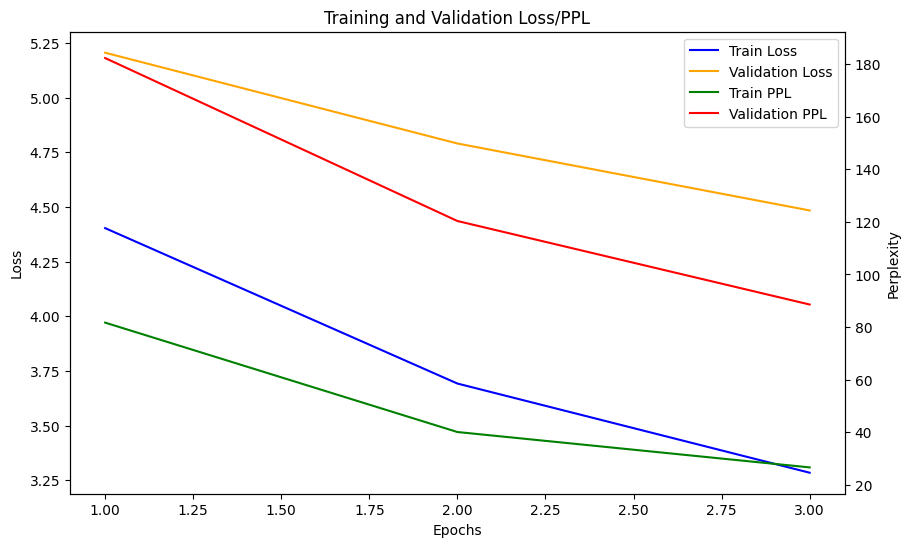

In [64]:
import matplotlib.pyplot as plt

epochs = [epoch+1 for epoch in range(N_EPOCHS)]

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

ax1.plot(epochs, train_losses, label='Train Loss', color='blue')
ax1.plot(epochs, valid_losses, label='Validation Loss', color='orange')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss/PPL')

ax2.plot(epochs, train_PPLs, label='Train PPL', color='green')
ax2.plot(epochs, valid_PPLs, label='Validation PPL', color='red')
ax2.set_ylabel('Perplexity')

ax2.set_ylim(bottom=min(min(train_PPLs), min(valid_PPLs)) - 10, 
             top=max(max(train_PPLs), max(valid_PPLs)) + 10)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper right')

plt.show()

# Inference and testing

In [126]:
src_vocab = vocab_transform['de']  # German vocabulary
trg_vocab = vocab_transform['en']  # English vocabulary

# Create the text transform dictionary
text_transforms = {}
text_transforms['de'] = sequential_transforms(
    token_transform['de'],
    vocab_transform['de'],
    tensor_transform_s  # Source tensor transform
)
text_transforms['en'] = sequential_transforms(
    token_transform['en'],
    vocab_transform['en'],
    tensor_transform_t  # Target tensor transform
)




#Create a def text transform function

def text_transform_src(text):
    # Tokenize and convert to indices
    tokens = de_tokenizer(text)  # Use your German tokenizer
    indices = [src_vocab[token] for token in tokens]
    return torch.LongTensor(indices)



# Create a generator function to generate translations for input source sequence

import torch.nn.functional as F

def generate_translation(model, src_sentence, max_len=50):
    model.eval()
    with torch.no_grad():
        # Use the text transform from dataloader
        src_tensor = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1).to(device)
        
        # Encode
        hidden, cell = model.encoder(src_tensor)
        
        # Start with <bos> token
        trg_indexes = [vocab_transform['en'].get_stoi()['<bos>']]
        
        # Generate translation
        for _ in range(max_len):
            trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
            output, hidden, cell = model.decoder(trg_tensor, hidden, cell)
            pred_token = output.argmax(1).item()
            trg_indexes.append(pred_token)
            
            if pred_token == vocab_transform['en'].get_stoi()['<eos>']:
                break
        
        # Convert indices to words
        trg_tokens = [vocab_transform['en'].get_itos()[i] for i in trg_indexes]
        
        # Clean up special tokens
        if trg_tokens[0] == '<bos>':
            trg_tokens = trg_tokens[1:]
        if trg_tokens[-1] == '<eos>':
            trg_tokens = trg_tokens[:-1]
        
        return " ".join(trg_tokens)

# Test translation
src_sentence = "Ich habe zwei Autos"
translation = generate_translation(model, src_sentence, max_len=50)
print(f"Source: {src_sentence}")
print(f"Translation: {translation}")

IndexError: list index out of range

In [84]:
# Evaluation metrics to evaluate the performance of the model 

'''
Work in progress... 
Metrics to evaluate be handled in future pull request
Consider using popular libraries such as NLTK and PyTorch 
(NLTK Library has implementation of BLEU evaluation metric that is a good candidate to get started)
'''

#TO DOS
    # DEFINE FUNCTION FOR CALCULATING BLEU SCORE
    # CALL FUNCTION TO CALL BLEU SCORE FOR HYPOTHESIS SENTENCES